# COGS 108 - Final Project
### - Amir Assad, A12721216
### - Danny Chan, A12458661

## Introduction and Background

### Background

### Significance 

### Research Question

### Hypothesis

In [1]:
# Imports
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as sm

## Data Description

### 1. Mass Shootings 2015 
* Link: http://www.gunviolencearchive.org/reports/mass-shootings/2015?page=1
* Number of observations: 173
* Description: 

### 2. NICS monthly figures on background checks for gun buyers
* Link: https://www.fbi.gov/file-repository/nics_firearm_checks_-_month_year_by_state_type.pdf/view
* Link: https://github.com/BuzzFeedNews/2017-11-gun-sales-estimates/blob/master/data/nics-firearm-background-checks.csv
* Number of observations: 12541
* Description: This NICS dataset contains the amount of background checks done for permits, handguns, long_guns, etc for every state per month from 1998 to 2017. This dataset will be used to to be a hypothesis on whether or not we have a correlation of background checks with the mass shootings. We will observe the total amount of background checks done for every state in 2015 and see if we are able to predict the number of incident occurence. We also think that the top 10 state for most mass shooting incident will overlap with the top 10 state with the most total background checks and handgun.

### 3. Murders by State, Types of Weapon, 2015 in US
* Link: https://ucr.fbi.gov/crime-in-the-u.s/2015/crime-in-the-u.s.-2015/tables/table-20/table_20_murder_by_state_types_of_weapons_2015.xls/@@template-layout-view?override-view=data-declaration
* Number of observations: 53
* Description:

## Data Cleaning/Pre-processing

In [2]:
# Import the data from all files into Dataframes
df_shootings = pd.read_csv(open('shootings.csv'))
df_background_checks = pd.read_csv(open('nics-firearm-background-checks.csv'))
murder_by_state_by_weapon = pd.read_csv(open("murderByStateByWeapon.csv"))

### Dataset 1

In [3]:
df_shootings.head()

,Incident Date,State,City Or County,Address,# Killed,# Injured,Operations
0,"December 31, 2015",Louisiana,New Orleans,1900 block of Amelia Street,0,6,NaN
1,"December 27, 2015",Tennessee,Jackson,North Parkway,0,4,NaN
2,"December 26, 2015",Pennsylvania,Philadelphia,4210 Macalester St,0,4,NaN
3,"December 25, 2015",Florida,Jacksonville,Franklin and Odessa,0,4,NaN
4,"December 25, 2015",Alabama,Mobile,785 Schillinger Rd S,0,4,NaN


Creating two new dataframe, one for the total number of incidents per state and another for total affected per state (injured + killed)

In [4]:
# Create two new dataframe
incident_count = {}
affected_count = {}
for i, row in df_shootings.iterrows():
    if row['State'] in incident_count:
        incident_count[row['State']] += 1
    else:
        incident_count[row['State']] = 1
        
    if row['State'] in affected_count:
        affected_count[row['State']] += (int(row['# Killed']) + int(row['# Injured']))
    else:
        affected_count[row['State']] = (int(row['# Killed']) + int(row['# Injured']))

In [5]:
# Swap the columns to be indexed of the dataframe
df_incident = pd.DataFrame([incident_count]).transpose()
df_affected = pd.DataFrame([affected_count]).transpose()
df_incident.columns = ['# Incident']
df_affected.columns = ['# Affected']

### Dataset 2

In [6]:
df_background_checks.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-10,Alabama,20017.0,252.0,6144.0,6999.0,308.0,337,0.0,15.0,...,0.0,0.0,0.0,14.0,18.0,1.0,0.0,0.0,0.0,36619
1,2017-10,Alaska,198.0,0.0,3153.0,3469.0,333.0,239,0.0,6.0,...,0.0,0.0,0.0,33.0,38.0,2.0,0.0,0.0,0.0,8080
2,2017-10,Arizona,6097.0,455.0,10614.0,8055.0,1100.0,689,0.0,10.0,...,0.0,0.0,0.0,30.0,17.0,1.0,1.0,0.0,0.0,29277
3,2017-10,Arkansas,3865.0,508.0,4873.0,7420.0,249.0,338,41.0,11.0,...,0.0,0.0,0.0,25.0,20.0,0.0,1.0,1.0,0.0,20327
4,2017-10,California,49259.0,0.0,39879.0,25749.0,3646.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119395


Parse the month column to add a near year column to bucket these data later

In [7]:
# Split the string by '-' and take the year
def extract_year (input):
    return int(input.split('-')[0])

# Apply new function on 'month' column and create new 'year' column
df_background_checks['year'] = df_background_checks['month'].apply(extract_year)

In [8]:
# Define function to create a new dataframe for specifc year and column
def create_bg_dataframe(df, year, column):
    temp_df = df[df['year'] == year]
    state_count = {}
    for i, row in temp_df.iterrows():
        if row['state'] in state_count:
            state_count[row['state']] += int(row[column])
        else:
            state_count[row['state']] = int(row[column])
    new_df = pd.DataFrame([state_count])
    new_df = new_df.transpose()
    return new_df

Create a new dataframe for the total background checks for states in 2015

In [9]:
df_2015_total = create_bg_dataframe(df_background_checks, 2015, 'totals')
df_2015_total.columns = ['total_background_checks']
df_2015_total_sorted = df_2015_total.sort_values('total_background_checks')[::-1]

Another dataframe for background checks done for handgun for state in 2015

In [10]:
df_2015_handgun = create_bg_dataframe(df_background_checks, 2015, 'handgun')
df_2015_handgun_sorted = df_2015_handgun.sort_values(0)[::-1]

Remove irrelevant years from the dataframe

In [11]:
df_2006_2015 = df_background_checks[df_background_checks['year'] >= 2006]
df_2006_2015 = df_2006_2015[df_background_checks['year'] <= 2015]

In [12]:
# Bucket by year for total count and handgun count
year_count_total = {}
year_count_handgun = {}
for i, row in df_2006_2015.iterrows():
    if row['year'] in year_count_total:
        year_count_total[row['year']] += int(row['totals'])
    else:
        year_count_total[row['year']] = int(row['totals'])
    if row['year'] in year_count_handgun:
        year_count_handgun[row['year']] += int(row['handgun'])
    else:
        year_count_handgun[row['year']] = int(row['handgun'])

Total count of background checks from 2006 to 2015

In [13]:
# Create dataframe from buckets for total 
df_year_total = pd.DataFrame([year_count_total])
df_year_total = df_year_total.transpose()
df_year_total.columns = ['total_count']
print(df_year_total)

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


Total count of background checks done for handgun from 2006 to 2015

In [14]:
# Create dataframe from buckets for handgun
df_year_handgun = pd.DataFrame([year_count_handgun])
df_year_handgun = df_year_handgun.transpose()
df_year_handgun.columns = ['handgun_count']
print(df_year_handgun)

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


### Dataset 3

In [15]:
murder_by_state_by_weapon.head()

,State,Total murders,Handguns,Rifles,Shotguns
0,Alabama,2,1,0,1
1,Alaska,15,12,2,1
2,Arizona,135,128,4,3
3,Arkansas,65,51,10,4
4,California,922,855,34,33


In [16]:
gun_types = ['Handguns','Shotguns', 'Rifles']
murder_by_state_by_weapon.set_index('State', inplace=True)
murders_by_state = murder_by_state_by_weapon[gun_types]


In [17]:
temp = []
for index, row in murders_by_state.iterrows():
    total = int(row.Handguns) + int(row.Shotguns) + int(row.Rifles)
    temp.append(total)
murders_by_state['Total murders'] = temp  

In [18]:
murder_by_state_by_weapon_VS_mass_shootings = pd.concat([murders_by_state, df_incident, df_affected], axis=1)
murder_by_state_by_weapon_VS_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings.fillna(0)

## Data Visualization

### Dataset 1

Sorted bar graph of state for total # of incidents and affected

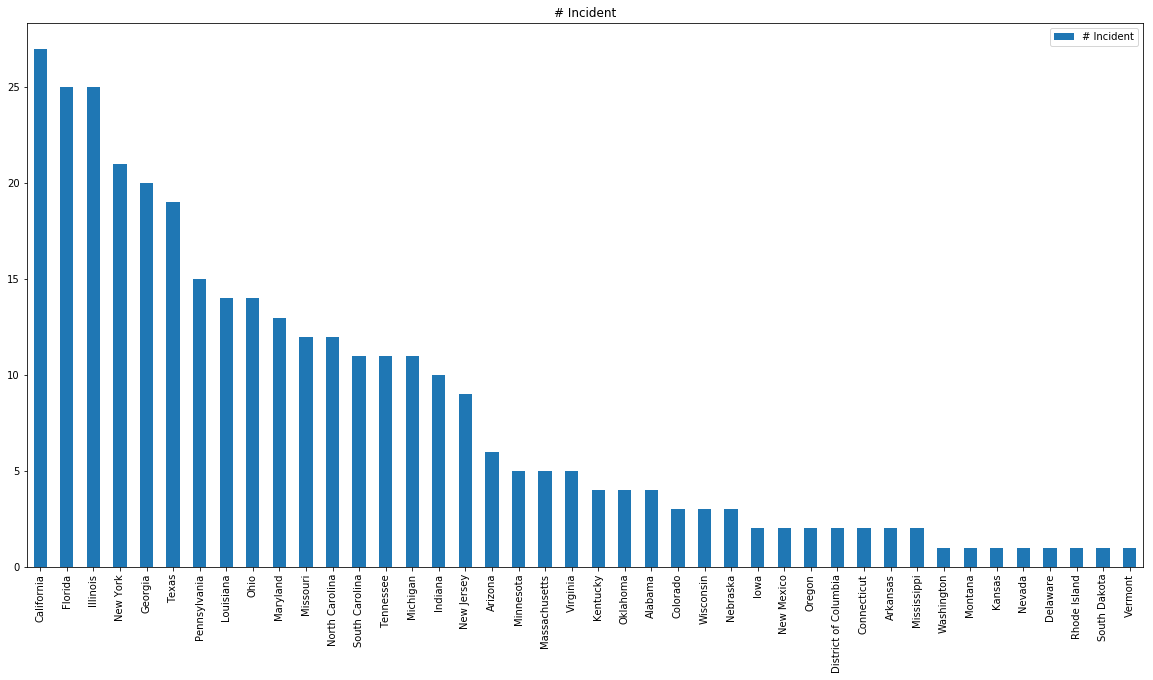

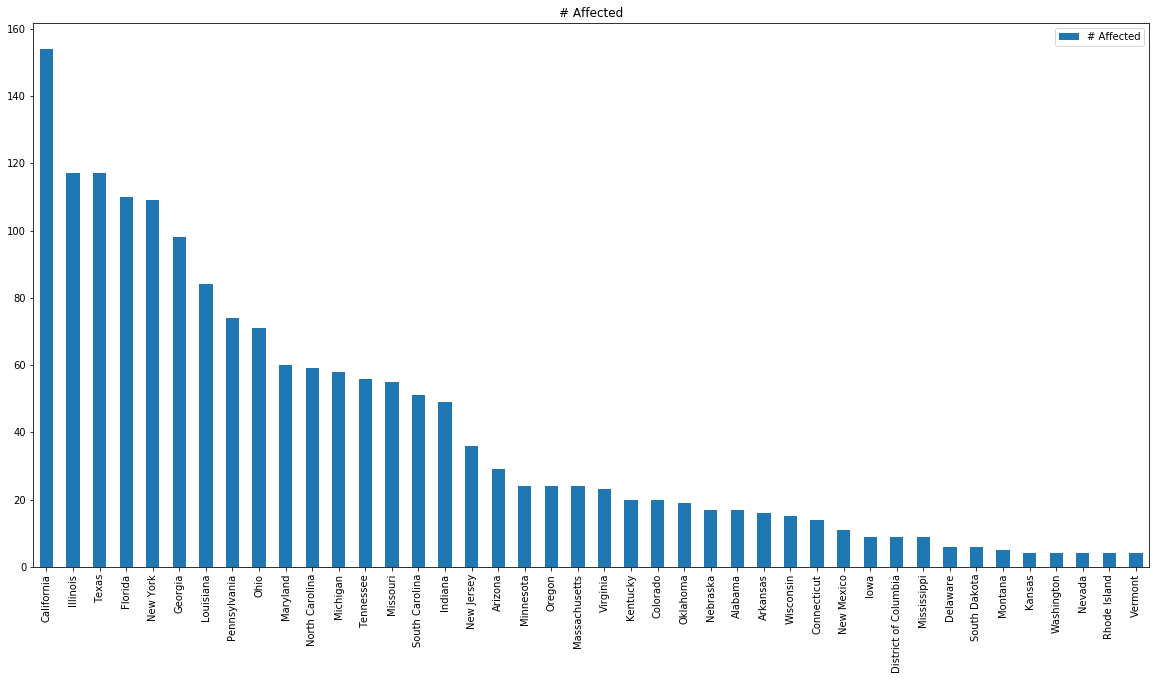

In [19]:
df_incident.sort_values('# Incident')[::-1].plot(kind='bar', figsize=(20,10), title='# Incident')
df_affected.sort_values('# Affected')[::-1].plot(kind='bar', figsize=(20,10), title='# Affected')

In [20]:
df_shootings_incident_affected = pd.concat([df_incident, df_affected], axis=1)
df_shootings_incident_affected.head()

,# Incident,# Affected
Alabama,4,17
Arizona,6,29
Arkansas,2,16
California,27,154
Colorado,3,20


### Dataset 2

For our background check dataset, we have the total amount of background checks and the top 10 states with the most background check in bar graphs. The purpose of this is we want to see if we can create a correlation of total background checks with shootings later. 

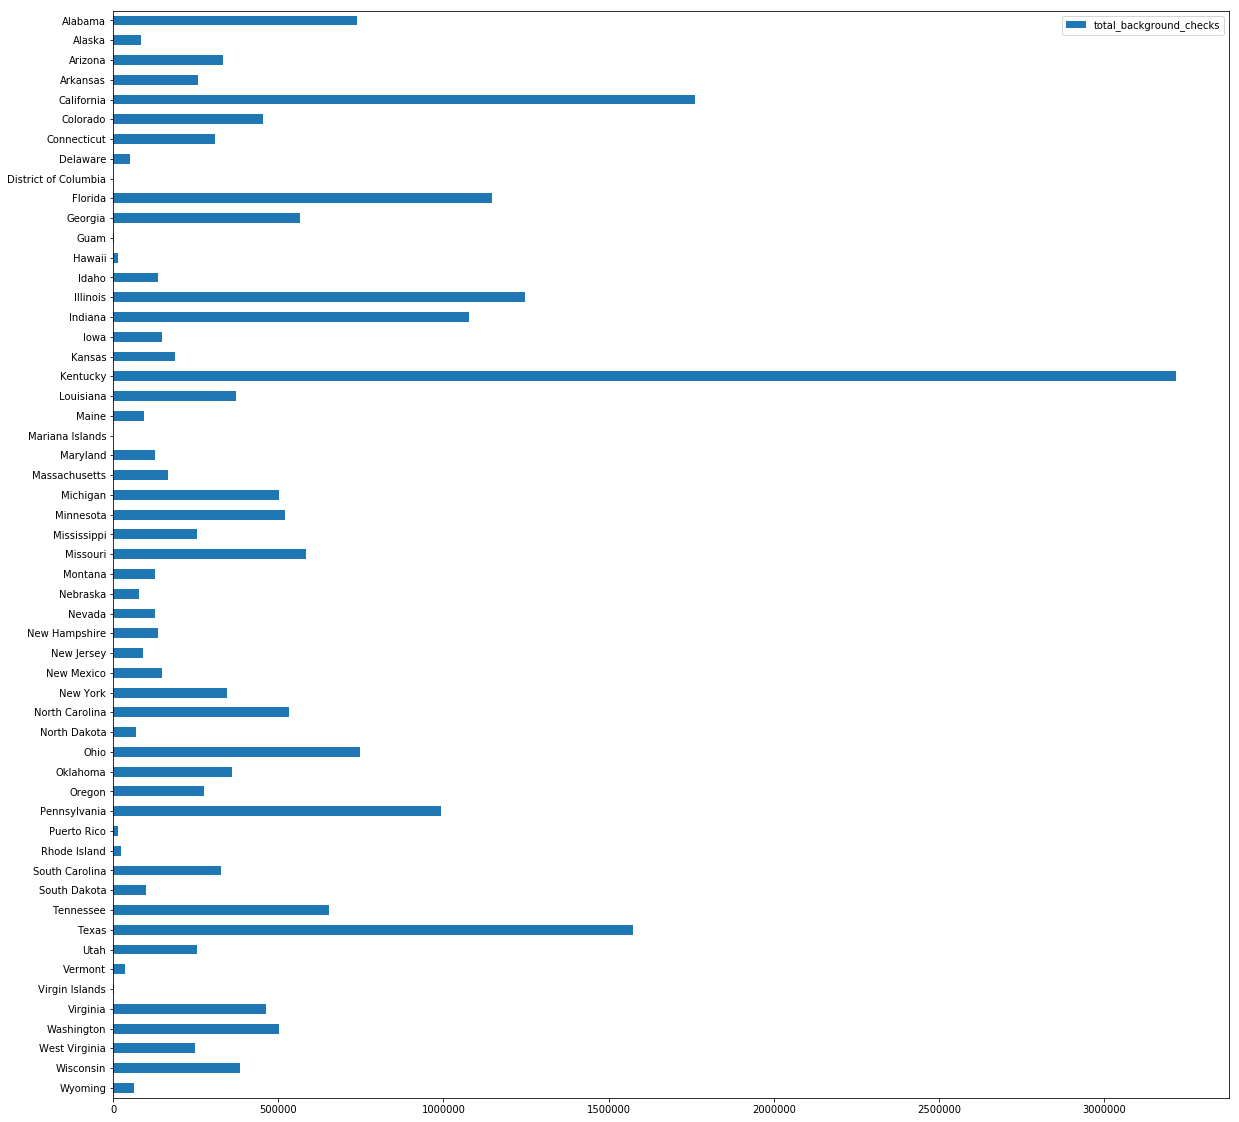

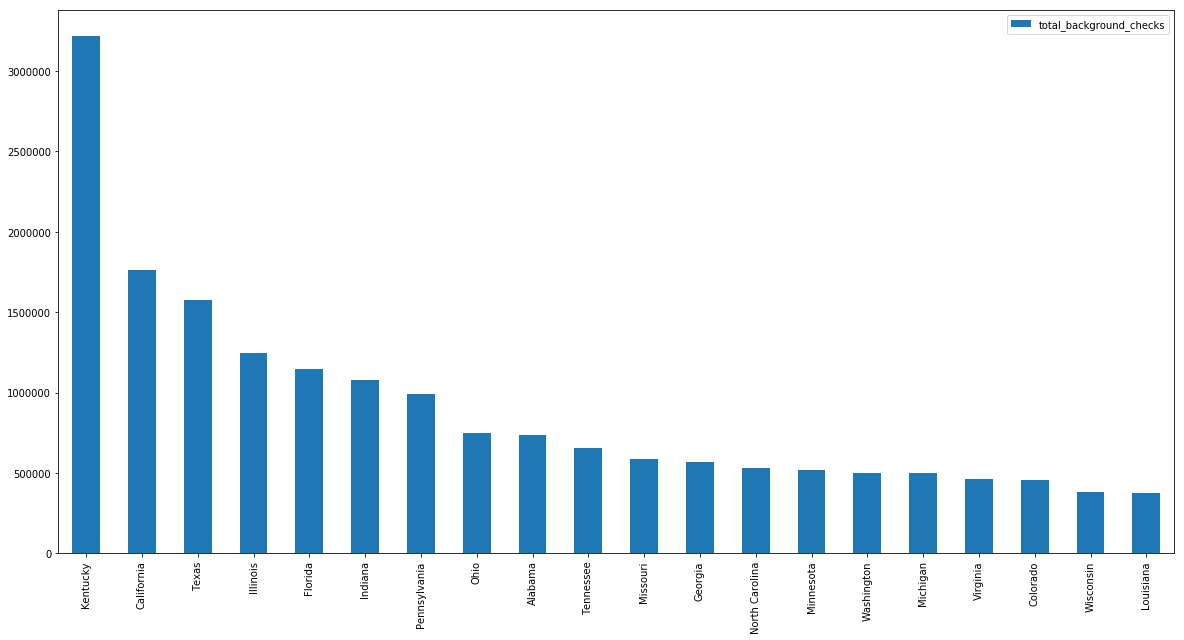

In [21]:
df_2015_total[::-1].plot(kind='barh', figsize=(20,20))
df_2015_total_sorted[:20].plot(kind='bar', figsize=(20,10))

The second dataframe we created from this datatset is the total of handgun background checks done in 2015. We have the total amount per state and the top 10 states with most handgun background checks. We have a secondary dataset we want to compare with the mass shootings, since we don't want to only think total background check is related.

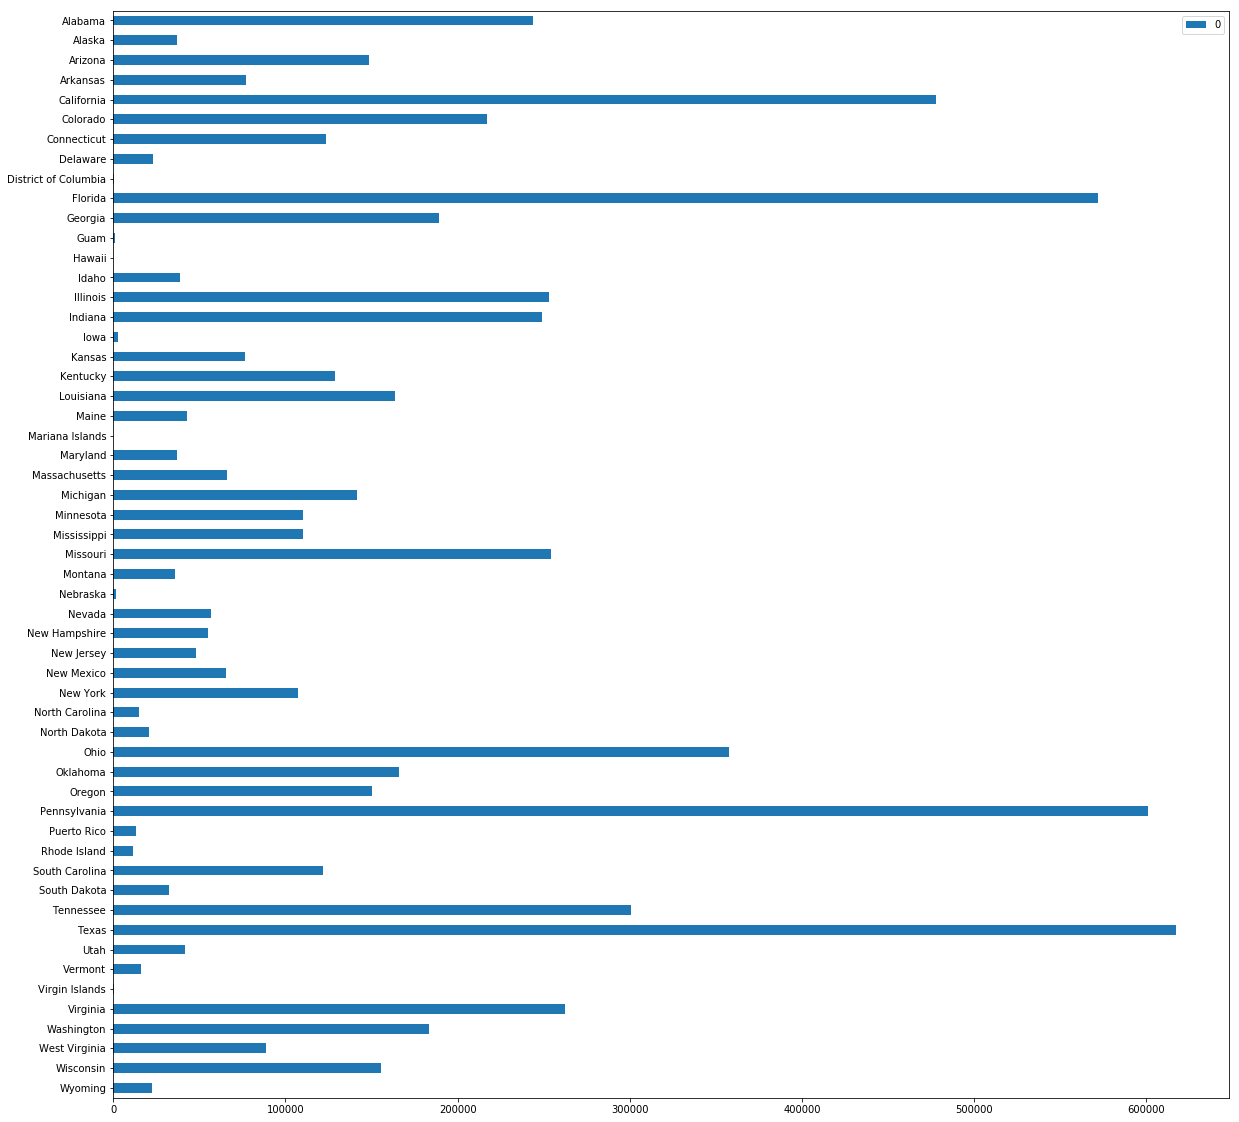

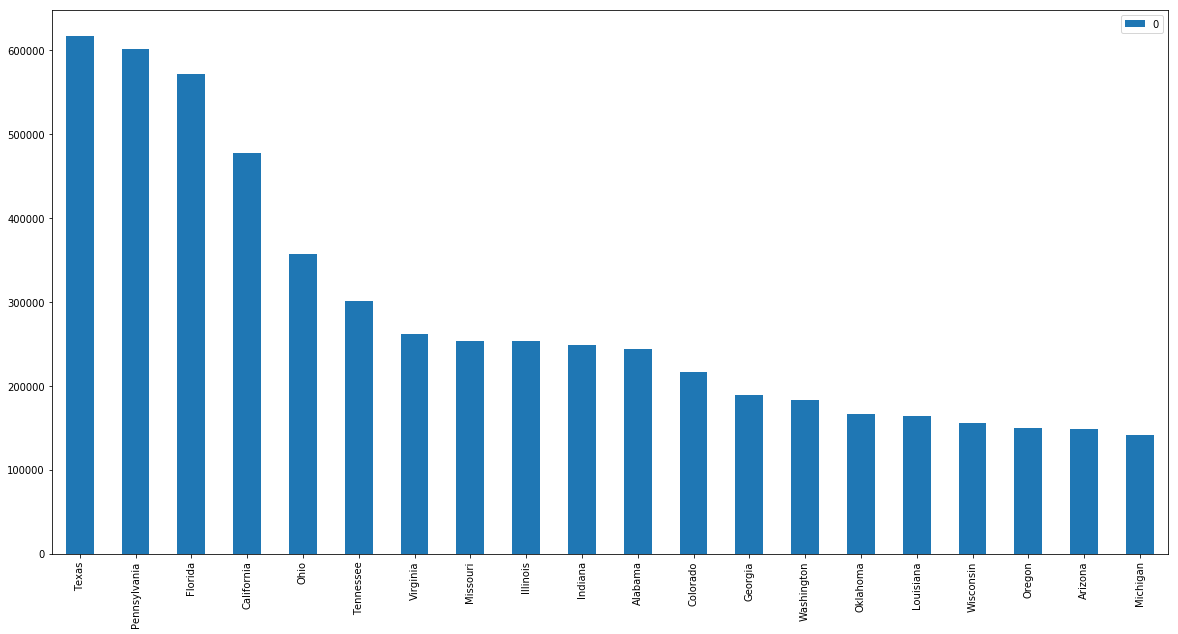

In [22]:
df_2015_handgun[::-1].plot(kind='barh', figsize=(20,20))
df_2015_handgun_sorted[:20].plot(kind='bar', figsize=(20,10))

We have a line graph of how the background checks increased over the past 10 years

      total_count
2006      9993057
2007     11162272
2008     12692985
2009     13984953
2010     14320489
2011     16336732
2012     19463832
2013     20966704
2014     20860241
2015     23026288


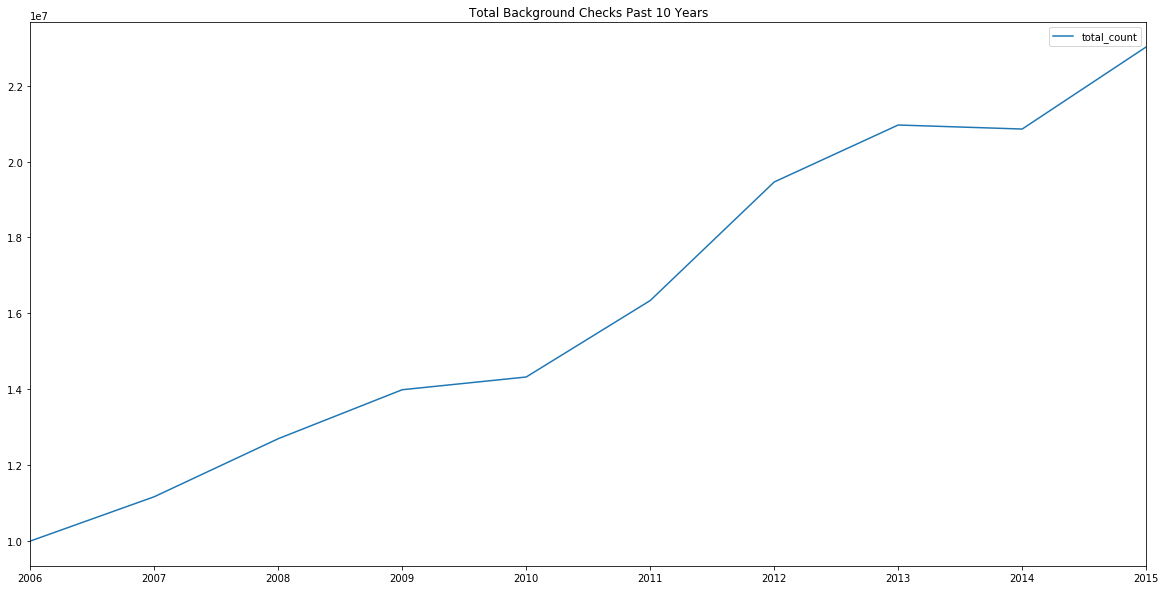

In [23]:
print(df_year_total)
df_year_total.plot(figsize=(20,10), title='Total Background Checks Past 10 Years')

We also have the total handgun background checks done over the past 10 years.

      handgun_count
2006        2441325
2007        2635629
2008        3331199
2009        3689604
2010        3678001
2011        4301389
2012        5682963
2013        6387502
2014        6199243
2015        7333808


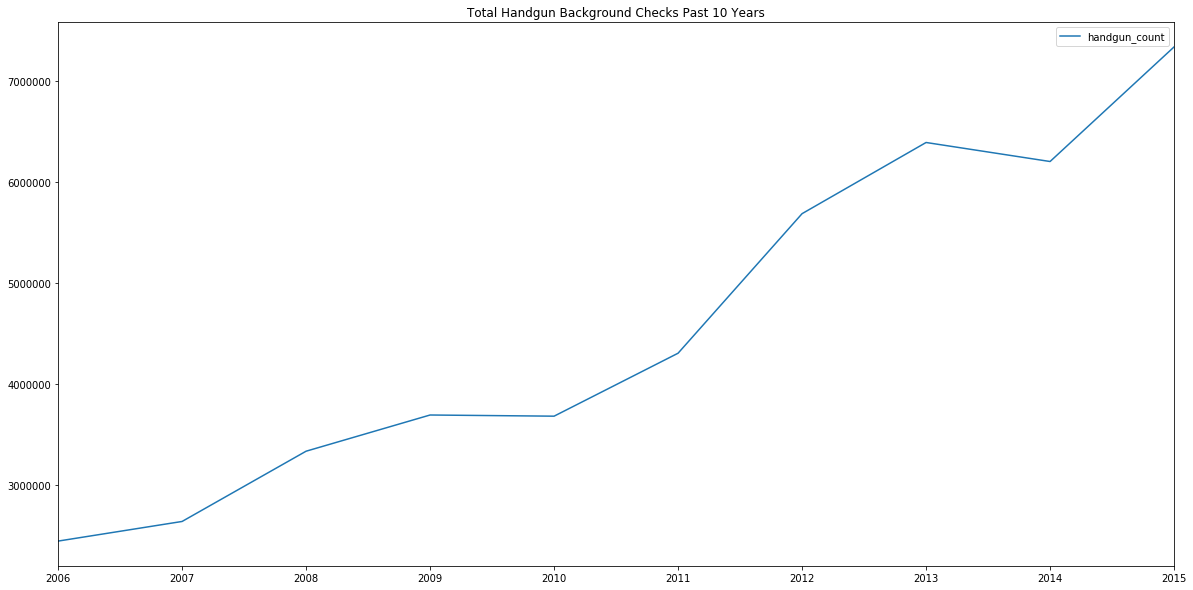

In [24]:
print(df_year_handgun)
df_year_handgun.plot(figsize=(20,10), title='Total Handgun Background Checks Past 10 Years')

### Dataset 3

In [25]:
murders_by_state[gun_types].head()

,Handguns,Shotguns,Rifles
State,,,
Alabama,1,1,0
Alaska,12,1,2
Arizona,128,3,4
Arkansas,51,4,10
California,855,33,34


[Text(0,0.5,'Murders'),
 Text(0.5,0,'State'),
 Text(0.5,1,'Murders per state by weapon')]

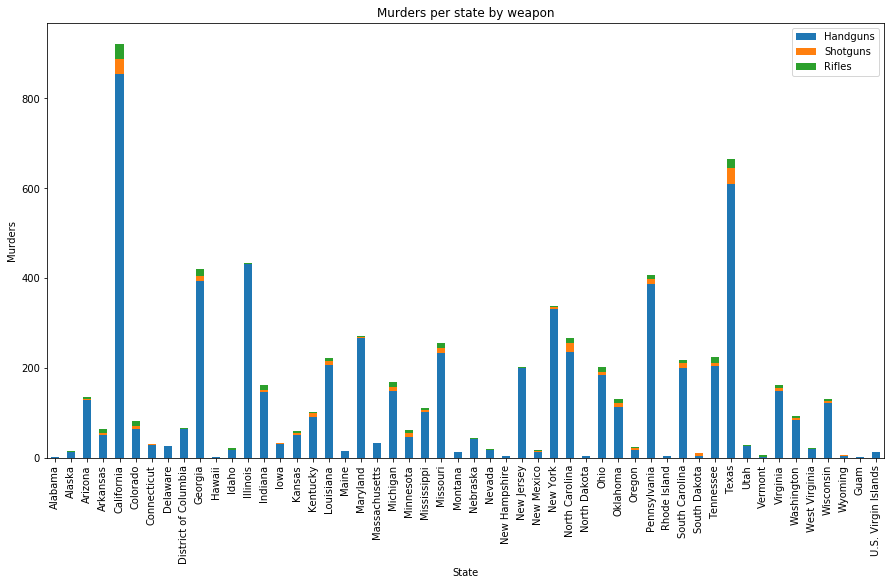

In [26]:
axes = murders_by_state[gun_types].plot.bar(figsize=(15,8), stacked=True)
axes.set(xlabel="State", ylabel="Murders", title="Murders per state by weapon")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10dbb36a0>], dtype=object)

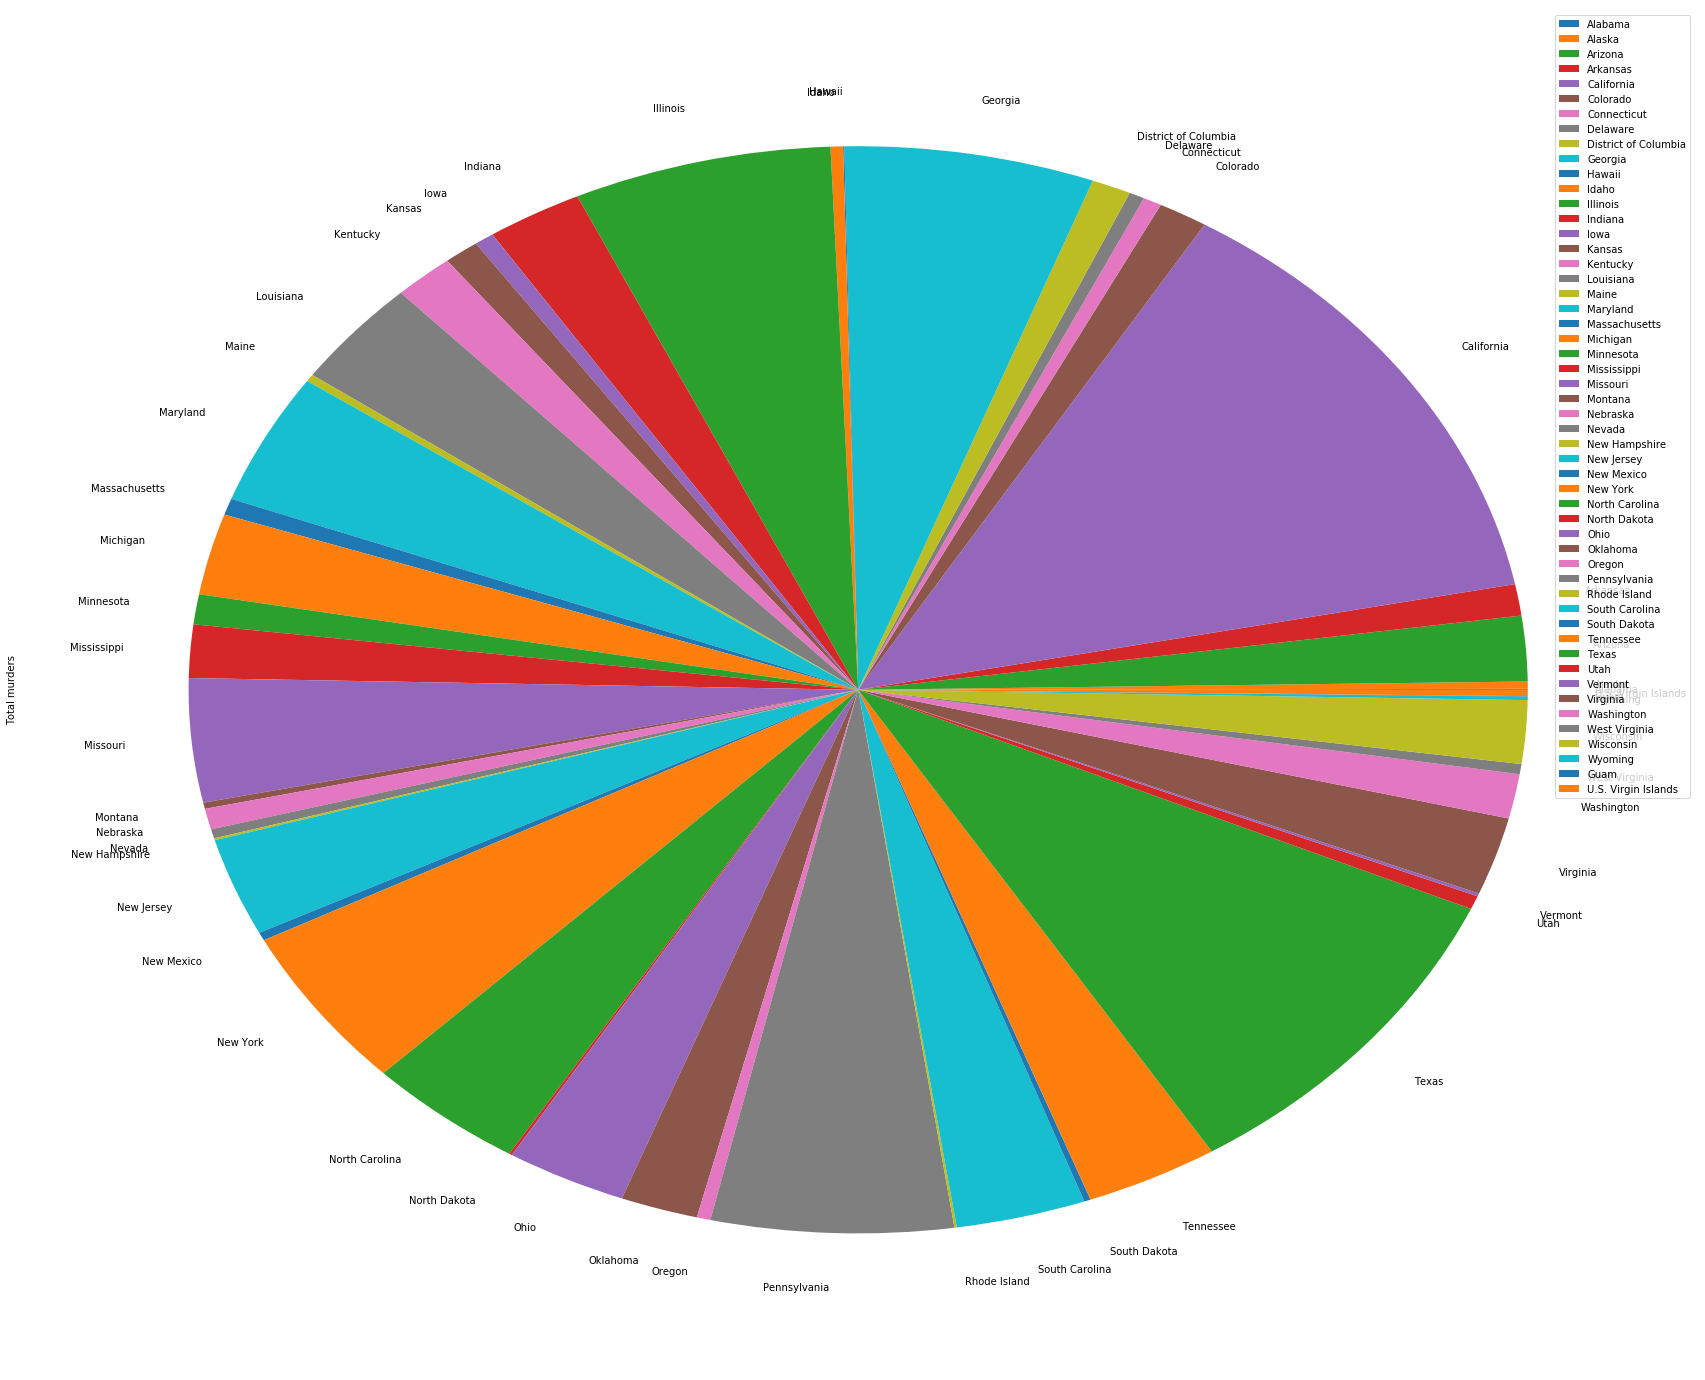

In [27]:
murders_by_state[['Total murders']].plot.pie(subplots=True, figsize=(30, 25))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c11cc91d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c1ec838d0>]], dtype=object)

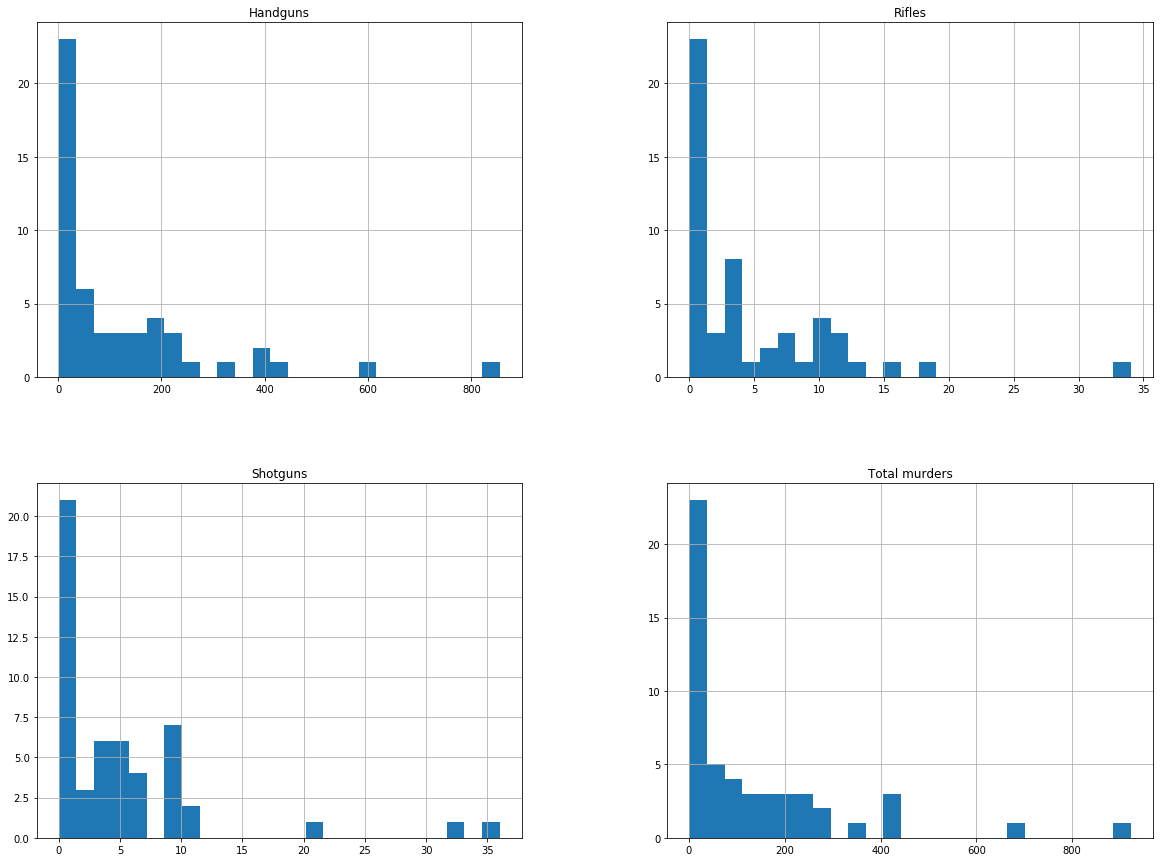

In [28]:
murders_by_state.hist(bins=25, weights=np.ones_like(murders_by_state[murders_by_state.columns[0]]), figsize=(20, 15))

## Data Analysis and Results

### Dataset 2

First we will combine our dataframe to do our analysis against of main dataframe, mass shootings. 

In [29]:
# Combine out original datatset with the mass shooting dataset 
df_2015_total_merge = pd.concat([df_2015_total, df_incident], axis=1)

# Since not all states has a incident, we will replace the NaN values with 0.
df_2015_total_merge.fillna(0, inplace=True)
df_2015_total_merge.head(20)

,total_background_checks,# Incident
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0
Colorado,454062,3.0
Connecticut,307750,2.0
Delaware,50416,1.0
District of Columbia,742,2.0
Florida,1147082,25.0


Used scatter matrix to analyze different the trend between the variable we have compare to the base table

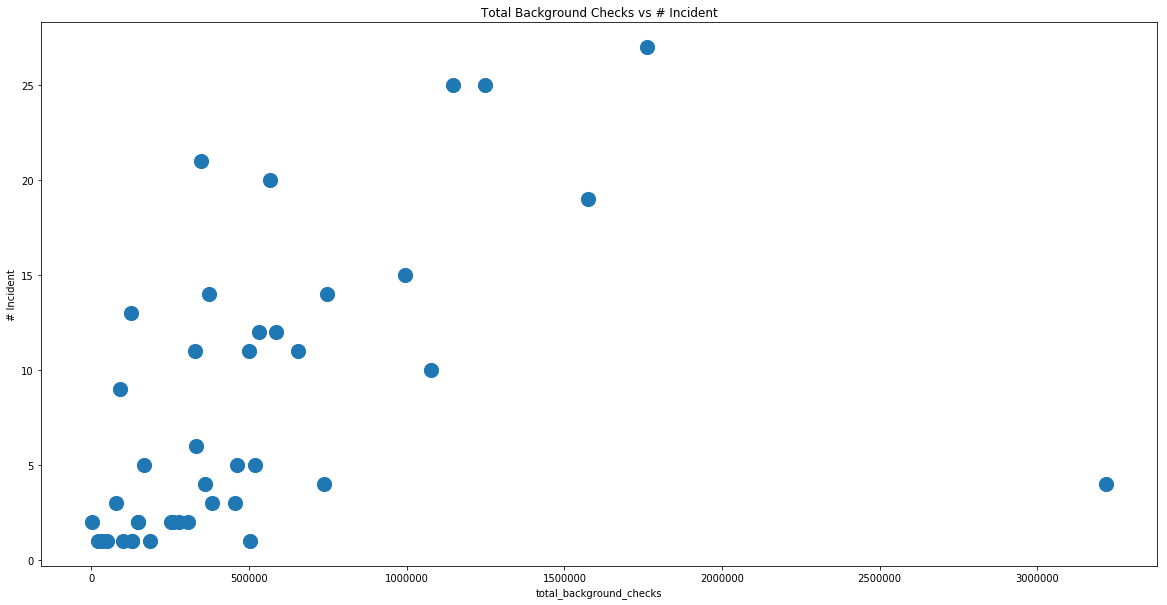

In [30]:
df_2015_total_merge[df_2015_total_merge['# Incident'] > 0].plot(x='total_background_checks', y='# Incident', kind='scatter', figsize=(20,10), s=200, title='Total Background Checks vs # Incident')

In [31]:
df_2015_total_merge.columns = ['total', 'incidents']
df_2015_total_merge.head()

,total,incidents
Alabama,737509,4.0
Alaska,85621,0.0
Arizona,331442,6.0
Arkansas,257346,2.0
California,1761079,27.0


Apply linear regression to see whether there are any correlation in our data with the base table.

In [32]:
df_2015_clean = df_2015_total_merge[df_2015_total_merge['incidents'] > 0]
out, pred = patsy.dmatrices('incidents ~ total', df_2015_clean)
mod = sm.OLS(out, pred)
res = mod.fit()

In [33]:
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     11.45
Date:                Tue, 20 Mar 2018   Prob (F-statistic):            0.00161
Time:                        16:47:29   Log-Likelihood:                -139.10
No. Observations:                  42   AIC:                             282.2
Df Residuals:                      40   BIC:                             285.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7702      1.405      3.396      0.0

Top 10 Most Background Checks vs Top 10 Most Incident

In [34]:
print(df_incident.sort_values('# Incident')[::-1].head(10))
print(df_2015_total_sorted.head(10))

              # Incident
California            27
Florida               25
Illinois              25
New York              21
Georgia               20
Texas                 19
Pennsylvania          15
Louisiana             14
Ohio                  14
Maryland              13
              total_background_checks
Kentucky                      3218371
California                    1761079
Texas                         1574266
Illinois                      1247398
Florida                       1147082
Indiana                       1076917
Pennsylvania                   993429
Ohio                           748502
Alabama                        737509
Tennessee                      654192


By looking at the intersection of the two list we have an overlap of 6 states.

In [35]:
list(set(df_incident.sort_values('# Incident')[::-1][:10].index).intersection(df_2015_total_sorted[:10].index))

['Ohio', 'Texas', 'California', 'Florida', 'Pennsylvania', 'Illinois']

We will now compare the handgun total in the same dataset, to see if the values will change

In [36]:
# Combine out original datatset with the mass shooting dataset 
df_2015_handgun_merge = pd.concat([df_2015_handgun, df_incident], axis=1)

# Since not all states has a incident, we will replace the NaN values with 0.
df_2015_handgun_merge.fillna(0, inplace=True)

Analyze the total handgun background check with # of incidents with linear regression to see if there's any correlation with these two datasets

In [37]:
df_2015_handgun_merge.columns = ['handgun', 'incidents']

# Drop rows with 0 incidents
df_2015_clean_handgun = df_2015_handgun_merge[df_2015_handgun_merge['incidents'] > 0]

# Perform OLS analysis
out, pred = patsy.dmatrices('incidents ~ handgun', df_2015_clean_handgun)
mod = sm.OLS(out, pred)
res = mod.fit()

In [38]:
print (res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     30.95
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           1.94e-06
Time:                        16:47:29   Log-Likelihood:                -132.35
No. Observations:                  42   AIC:                             268.7
Df Residuals:                      40   BIC:                             272.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7084      1.296      2.090      0.0

From analyzing the data with just handgun we came to similiar results from total background checks.

In [39]:
list(set(df_incident.sort_values('# Incident')[::-1][:10].index).intersection(df_2015_handgun_sorted[:10].index))

['Ohio', 'Texas', 'California', 'Florida', 'Pennsylvania', 'Illinois']

### Dataset 3

In [40]:
murder_by_state_by_weapon_VS_mass_shootings.head()

,Handguns,Shotguns,Rifles,Total murders,# Incident,# Affected
Alabama,1.0,1.0,0.0,2.0,4.0,17.0
Alaska,12.0,1.0,2.0,15.0,0.0,0.0
Arizona,128.0,3.0,4.0,135.0,6.0,29.0
Arkansas,51.0,4.0,10.0,65.0,2.0,16.0
California,855.0,33.0,34.0,922.0,27.0,154.0


In [41]:
sns.set(rc={'figure.figsize':(20,10)})

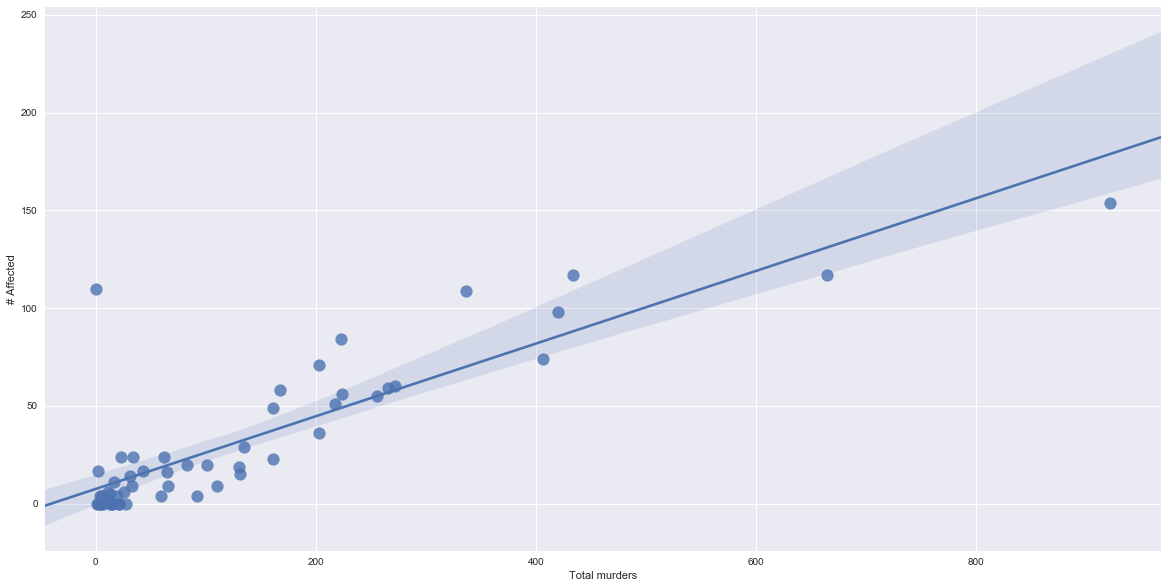

In [42]:
sns.regplot(x='Total murders', y='# Affected', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True,  scatter_kws={'s':150 })

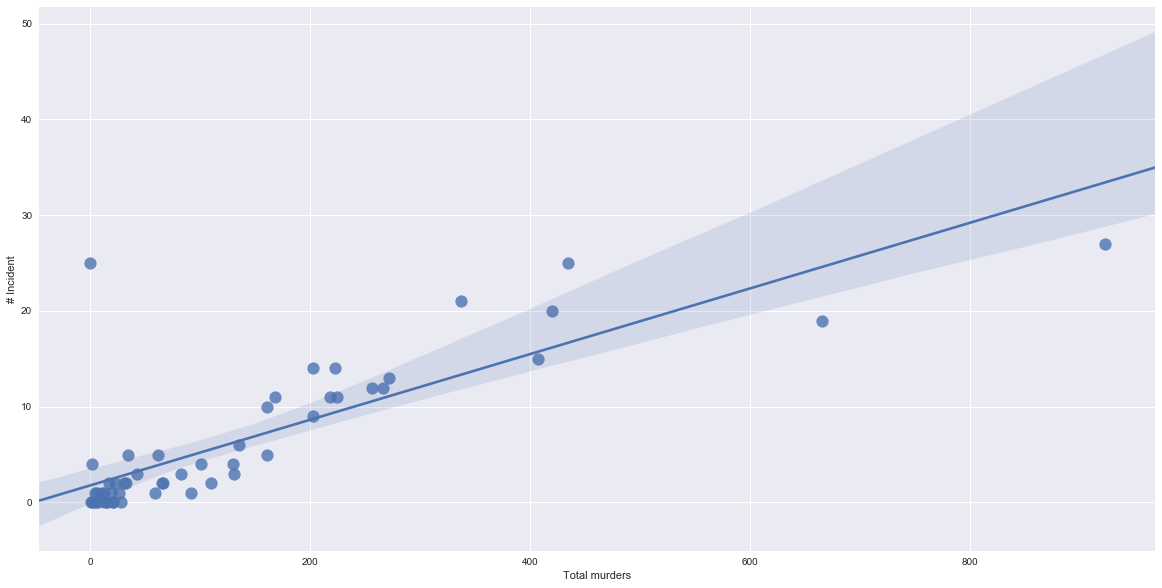

In [43]:
sns.regplot(x='Total murders', y='# Incident', data=murder_by_state_by_weapon_VS_mass_shootings, fit_reg=True, scatter_kws={'s':150 }) 

In [44]:
total_murders_VS_mass_shooting_incidents = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Incident']]
total_murders_VS_people_affected_in_mass_shootings = murder_by_state_by_weapon_VS_mass_shootings[['Total murders','# Affected']]

In [45]:
total_murders_VS_mass_shooting_incidents.columns = ['murders', 'incidents']
total_murders_VS_people_affected_in_mass_shootings.columns = ['murders', 'affected']

In [46]:
total_murders_VS_mass_shooting_incidents.head()

,murders,incidents
Alabama,2.0,4.0
Alaska,15.0,0.0
Arizona,135.0,6.0
Arkansas,65.0,2.0
California,922.0,27.0


In [47]:
out, pred = patsy.dmatrices('incidents ~ murders', total_murders_VS_mass_shooting_incidents)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              incidents   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.659
Method:                 Least Squares   F-statistic:                     101.5
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           1.01e-13
Time:                        16:47:30   Log-Likelihood:                -152.50
No. Observations:                  53   AIC:                             309.0
Df Residuals:                      51   BIC:                             312.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7724      0.750      2.362      0.0

In [48]:
total_murders_VS_people_affected_in_mass_shootings.head()

,murders,affected
Alabama,2.0,17.0
Alaska,15.0,0.0
Arizona,135.0,29.0
Arkansas,65.0,16.0
California,922.0,154.0


In [49]:
out, pred = patsy.dmatrices('affected ~ murders', total_murders_VS_people_affected_in_mass_shootings)
mod = sm.OLS(out, pred)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               affected   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     146.3
Date:                Tue, 20 Mar 2018   Prob (F-statistic):           1.34e-16
Time:                        16:47:30   Log-Likelihood:                -232.31
No. Observations:                  53   AIC:                             468.6
Df Residuals:                      51   BIC:                             472.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.5677      3.382      2.238      0.0

## Privacy/Ethics Considerations

## Conclusion and Discussion